In [1]:
# === GPU setup & speed-ups (override) ===
import os, torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
if DEVICE.type == 'cuda':
    torch.backends.cudnn.benchmark = True  # good when input sizes are consistent
    try:
        torch.set_float32_matmul_precision('high')  # Ampere+ TF32 speed-up
    except Exception:
        pass

# Helper to move tensors/models
def to_device(x):
    return x.to(DEVICE, non_blocking=True) if hasattr(x, 'to') else x


Using device: cuda


In [ ]:

# === Setup & Configuration (preconfigured for your dataset) ===
# You may need to install some packages in your environment:
# !pip install pydicom scikit-image scikit-learn tqdm torch torchvision

import os
from pathlib import Path
import json
import random
import math
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

# Optional: if working directly from DICOM
try:
    import pydicom
    HAS_PYDICOM = True
except Exception:
    HAS_PYDICOM = False

from skimage.transform import resize
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

# -----------------------------
# Configured for your dataset
# -----------------------------
DATA_DIR = Path(r"C:\Users\Acer\OneDrive\Desktop\4MDS - Prince\Research!!\MRNet\MRNet-v1.0")
OUTPUT_DIR = Path("./mrnet_paper_out")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Splits: we have only train & valid, so use valid as tuning too
TRAIN_SPLIT = "train"
TUNE_SPLIT = "valid"   # reuse valid as tuning (paper uses a tuning set)
VALID_SPLIT = "valid"

# Planes used in the paper for the internal dataset
PLANES = {
    "axial": "PD",
    "coronal": "T1",
    "sagittal": "T2"
}

# Labels CSVs: expected columns = ["case", "abnormal", "acl", "meniscus"]
LABELS_FILES = {
    "train": DATA_DIR / "train_labels.csv",
    "tune":  DATA_DIR / "valid_labels.csv",  # reuse valid
    "valid": DATA_DIR / "valid_labels.csv"
}

# You said files are .npy per case:
#  DATA_DIR/{split}/{plane}/{case}.npy  with shape [num_slices, H, W] or [num_slices, 3, H, W]
INPUT_LAYOUT = "NPY"  # "DICOM" | "PNG" | "NPY"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
print(f"pydicom available: {HAS_PYDICOM}")
print("DATA_DIR:", DATA_DIR)
print("INPUT_LAYOUT:", INPUT_LAYOUT)
print("Using VALID as tuning split (TUNE_SPLIT='valid').")


Device: cuda
pydicom available: False
DATA_DIR: C:\Users\Acer\OneDrive\Desktop\4MDS - Prince\Research!!\MRNet\MRNet-v1.0
INPUT_LAYOUT: NPY
Using VALID as tuning split (TUNE_SPLIT='valid').



## Preprocessing (paper)

Per-series steps (sagittal T2, coronal T1, axial PD):
1. Read slices, resize to **256×256**.
2. Apply **Nyúl–Udupa histogram-based intensity standardization** using **landmarks from the training set of the same plane/sequence**.
3. **Clip to [0, 255]** and cast to `uint8`.
4. Replicate channel to **3** for AlexNet.


In [3]:

# === Intensity Standardization (Nyúl & Udupa style) ===
import bisect

PCTS = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]
TARGET_MIN, TARGET_MAX = 0.0, 255.0

def compute_landmarks(arr: np.ndarray, pcts=PCTS) -> np.ndarray:
    if arr.ndim == 4 and arr.shape[1] == 3:
        arr = arr.mean(axis=1)
    flat = arr.reshape(-1)
    return np.percentile(flat, pcts).astype(np.float32)

def average_landmarks(landmarks_list: List[np.ndarray]) -> np.ndarray:
    return np.mean(np.stack(landmarks_list, axis=0), axis=0)

def piecewise_linear_map(x: np.ndarray, src_pts: np.ndarray, dst_pts: np.ndarray) -> np.ndarray:
    sp = np.concatenate([[src_pts[0] - 1e-6], src_pts, [src_pts[-1] + 1e-6]])
    dp = np.concatenate([[TARGET_MIN], dst_pts, [TARGET_MAX]])
    x_flat = x.reshape(-1)
    inds = np.searchsorted(sp, x_flat, side="right") - 1
    inds = np.clip(inds, 0, len(sp) - 2)
    x0, x1 = sp[inds], sp[inds+1]
    y0, y1 = dp[inds], dp[inds+1]
    denom = np.maximum(x1 - x0, 1e-6)
    y = y0 + (x_flat - x0) * (y1 - y0) / denom
    return y.reshape(x.shape)

def fit_reference_landmarks(train_series: List[np.ndarray]) -> np.ndarray:
    lms = [compute_landmarks(s) for s in train_series]
    return average_landmarks(lms)

def standardize_series(arr: np.ndarray, src_landmarks: np.ndarray, ref_landmarks: np.ndarray) -> np.ndarray:
    mapped = piecewise_linear_map(arr.astype(np.float32), src_landmarks, ref_landmarks)
    mapped = np.clip(mapped, TARGET_MIN, TARGET_MAX)
    return mapped.astype(np.uint8)


In [4]:

# === Series Loading Utilities ===
from skimage.transform import resize
from PIL import Image

def load_series_npy(npy_path: Path) -> np.ndarray:
    arr = np.load(npy_path)
    if arr.ndim == 3:
        if arr.shape[-1] != 256 or arr.shape[-2] != 256:
            arr = np.stack([resize(s, (256, 256), preserve_range=True, anti_aliasing=True) for s in arr], axis=0)
        return arr.astype(np.float32)
    elif arr.ndim == 4 and arr.shape[1] == 3:
        arr = arr.mean(axis=1)
        if arr.shape[-1] != 256 or arr.shape[-2] != 256:
            arr = np.stack([resize(s, (256, 256), preserve_range=True, anti_aliasing=True) for s in arr], axis=0)
        return arr.astype(np.float32)
    else:
        raise ValueError(f"Unsupported .npy shape: {arr.shape}")

def to_3ch_uint8(arr: np.ndarray) -> np.ndarray:
    if arr.dtype != np.uint8:
        arr = np.clip(arr, 0, 255).astype(np.uint8)
    return np.repeat(arr[:, None, :, :], 3, axis=1)

def enumerate_case_ids(labels_csv: Path) -> List[str]:
    import pandas as pd
    df = pd.read_csv(labels_csv, dtype={"case": str})
    return df["case"].tolist()

def get_series_path(split: str, plane: str, case_id: str) -> Path:
    base = DATA_DIR / split / plane
    if INPUT_LAYOUT == "NPY":
        return base / f"{case_id}.npy"
    else:
        raise ValueError("This configured notebook expects NPY layout.")


In [5]:

# === Learn Reference Landmarks (per plane/sequence) from TRAIN set ===
import pandas as pd

REF_LANDMARKS = {}
MAX_CASES_FOR_LM = 200  # increase for more stable landmarks

train_ids = enumerate_case_ids(LABELS_FILES["train"])

for plane, seq in PLANES.items():
    lm_series = []
    ids_sample = random.sample(train_ids, min(len(train_ids), MAX_CASES_FOR_LM))
    for cid in tqdm(ids_sample, desc=f"Fitting landmarks for {plane}-{seq}"):
        ser_path = get_series_path("train", plane, cid)
        if not ser_path.exists():
            continue
        vol = load_series_npy(ser_path)  # [S,H,W]
        lm_series.append(vol)
    if not lm_series:
        print(f"WARNING: No series found for {plane}. Skipping landmarks; will passthrough raw.")
        REF_LANDMARKS[plane] = None
    else:
        ref = fit_reference_landmarks(lm_series)
        REF_LANDMARKS[plane] = ref
        np.save(OUTPUT_DIR / f"ref_landmarks_{plane}.npy", ref)

print({k: (None if v is None else v.tolist())[:3] for k,v in REF_LANDMARKS.items()})


Fitting landmarks for sagittal-T2: 100%|██████████| 200/200 [00:03<00:00, 59.03it/s]


{'axial': [0.0, 9.875, 13.720000267028809], 'coronal': [0.0, 4.054999828338623, 6.269999980926514], 'sagittal': [0.0, 15.020000457763672, 19.639999389648438]}


In [6]:
# === Simple Series-Consistent Tight Crop (NEW) ===
import numpy as np
from PIL import Image

def _resize_slice_uint8(img2d, size=(256,256)):
    return np.array(Image.fromarray(img2d.astype(np.uint8)).resize(size, resample=Image.BILINEAR), dtype=np.uint8)

def series_bbox_simple(vol, p=75, margin=16):
    """Compute a bbox from a mean projection (percentile threshold), series-consistent.
    vol: [S,H,W] or [S,3,H,W] uint8/float. Returns (y0,y1,x0,x1).
    """
    if vol.ndim == 4 and vol.shape[1] in (1,3):
        vol_gray = vol.mean(axis=1)
    elif vol.ndim == 3:
        vol_gray = vol
    else:
        raise ValueError(f"Unexpected volume shape {vol.shape}")
    S, H, W = vol_gray.shape
    proj = vol_gray.mean(axis=0)
    thr  = np.percentile(proj, p)
    mask = proj >= thr
    if not mask.any():
        return (0, H, 0, W)
    ys, xs = np.where(mask)
    y0, y1 = max(0, int(ys.min())-margin), min(H, int(ys.max())+1+margin)
    x0, x1 = max(0, int(xs.min())-margin), min(W, int(xs.max())+1+margin)
    return (y0,y1,x0,x1)

def crop_and_resize_series_simple(vol, out_size=(256,256), p=75, margin=16):
    y0,y1,x0,x1 = series_bbox_simple(vol, p=p, margin=margin)
    if vol.ndim == 3:
        cropped = vol[:, y0:y1, x0:x1]
        out = np.stack([_resize_slice_uint8(s, out_size) for s in cropped], axis=0)
    else:
        cropped = vol[:, :, y0:y1, x0:x1]
        out = np.stack([np.stack([_resize_slice_uint8(c, out_size) for c in s], axis=0)
                        for s in cropped], axis=0)
    return out, (y0,y1,x0,x1)



## Augmentation (paper)

During training (slice-wise per series):
- Random rotation ∈ [−25°, +25°]
- Random translation (x, y) ∈ [−25, +25] px
- Random horizontal flip with p=0.5


In [7]:
# === Slice-wise Augmentations (paper + CHANGES) ===
import torchvision.transforms.functional as TF
import random
def augment_series_uint8_3ch(arr_3ch: np.ndarray) -> np.ndarray:
    S = arr_3ch.shape[0]
    # CHANGED: gentler affine (±12°, ±12 px, scale 0.95–1.05, shear ±8°) and mild B/C jitter (±0.15)
    angle = random.uniform(-12.0, 12.0)
    translate = (random.randint(-12, 12), random.randint(-12, 12))
    scale = random.uniform(0.95, 1.05)
    shear = random.uniform(-8.0, 8.0)
    do_flip = random.random() < 0.5
    b_fac = 1.0 + random.uniform(-0.15, 0.15)
    c_fac = 1.0 + random.uniform(-0.15, 0.15)
    out = []
    for s in range(S):
        img = Image.fromarray(np.transpose(arr_3ch[s], (1,2,0)))  # HWC
        img = TF.affine(img, angle=angle, translate=translate, scale=scale, shear=shear, fill=0)
        if do_flip:
            img = TF.hflip(img)
        # CHANGED: mild brightness/contrast jitter (series-consistent)
        img = TF.adjust_brightness(img, b_fac)
        img = TF.adjust_contrast(img, c_fac)
        out.append(np.transpose(np.array(img, dtype=np.uint8), (2,0,1)))
    return np.stack(out, axis=0)


In [8]:

# === Dataset & DataLoader ===
TASKS = ["abnormal", "acl", "meniscus"]

class MRNetSeriesDataset(Dataset):
    def __init__(self, split: str, plane: str, labels_csv: Path, training: bool):
        self.split = split
        self.plane = plane
        self.labels_df = pd.read_csv(labels_csv, dtype={"case": str})
        self.ids = self.labels_df["case"].tolist()
        self.training = training
        self.ref_lm = REF_LANDMARKS.get(plane, None)

    def __len__(self):
        return len(self.ids)

    def _preprocess(self, vol: np.ndarray) -> np.ndarray:
        if self.ref_lm is not None:
            src_lm = compute_landmarks(vol)
            vol = standardize_series(vol, src_lm, self.ref_lm)
        else:
            vol = np.clip(vol, 0, 255).astype(np.uint8)
                # CHANGED: add tight knee crop (series-consistent) before channel replication
        vol, _ = crop_and_resize_series_simple(vol, out_size=(256,256), p=75, margin=20)
        vol_3ch = to_3ch_uint8(vol)  # [S,3,256,256]
        return vol_3ch

    def __getitem__(self, idx: int):
        cid = self.ids[idx]
        ser_path = get_series_path(self.split, self.plane, cid)
        vol = load_series_npy(ser_path)          # [S,H,W], float
        vol3 = self._preprocess(vol)             # [S,3,256,256] uint8

        if self.training:
            vol3 = augment_series_uint8_3ch(vol3)

        t = torch.from_numpy(vol3.astype(np.float32) / 255.0)  # [S,3,256,256]
        y = self.labels_df.iloc[idx][TASKS].astype(np.float32).values
        y = torch.from_numpy(y)
        return t, y, cid


In [9]:

# === MRNet Model (AlexNet features -> GAP -> Max-over-slices -> FC) ===
from torchvision import models

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1).features
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        B, S = x.shape[:2]
        x = x.reshape(B*S, 3, 256, 256)
        feats = self.features(x)
        pooled = self.gap(feats).squeeze(-1).squeeze(-1)  # [B*S,256]
        pooled = pooled.reshape(B, S, 256)
        series_vec, _ = pooled.max(dim=1)                 # [B,256]
        out = self.fc(self.dropout(series_vec))           # [B,1]
        return out  # logits

    def features_2d(self, x2d):
        return self.features(x2d)


In [19]:
# === Training Helpers ===
from sklearn.metrics import roc_auc_score
AUC_HISTORY = {}

def compute_pos_weight(labels_df: pd.DataFrame, task: str, device: str = DEVICE) -> torch.Tensor:
    pos = labels_df[task].sum()
    neg = len(labels_df) - pos
    if pos == 0:
        w = torch.tensor([1.0], device=device)
    else:
        w = torch.tensor([neg / max(pos, 1.0)], device=device)
    return w

def train_one_mrnet_for_task(
    plane: str,
    task_idx: int,
    epochs: int = 50,
    lr: float = 1e-5,
    wd: float = 1e-2,
    seed: int = 42
):
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    task = TASKS[task_idx]
    print(f"\n=== Train MRNet for plane={plane}, task={task} ===")

    ds_tr = MRNetSeriesDataset("train", plane, LABELS_FILES["train"], training=True)
    ds_tu = MRNetSeriesDataset("valid", plane, LABELS_FILES["valid"], training=False)
    dl_tr = DataLoader(ds_tr, batch_size=1, shuffle=True,  num_workers=2, pin_memory=True)
    dl_tu = DataLoader(ds_tu, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

    model = MRNet().to(DEVICE)
    pos_weight = compute_pos_weight(ds_tr.labels_df, task).to(DEVICE)
    criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optim      = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_loss = float("inf")
    ckpt_dir  = OUTPUT_DIR / "cnn_checkpoints" / plane / task
    ckpt_dir.mkdir(parents=True, exist_ok=True)
    best_path = ckpt_dir / f"best_{plane}_{task}.pt"   # fixed f-string

    for ep in range(1, epochs + 1):
        # -------- Train --------
        model.train()
        running = 0.0
        for x, y, _ in dl_tr:
            x = x.to(DEVICE)
            y_task = y[:, task_idx].to(DEVICE).float().unsqueeze(1)

            logits = model(x)
            loss   = criterion(logits, y_task)

            optim.zero_grad()
            loss.backward()
            optim.step()

            running += loss.item()

        tr_loss = running / max(1, len(dl_tr))

        # -------- Validate + AUC --------
        model.eval()
        running = 0.0
        all_probs, all_true = [], []
        with torch.no_grad():
            for x, y, _ in dl_tu:
                x = x.to(DEVICE)
                y_task = y[:, task_idx].to(DEVICE).float().unsqueeze(1)

                logits = model(x)
                loss   = criterion(logits, y_task)
                running += loss.item()

                all_probs.extend(torch.sigmoid(logits).cpu().numpy().ravel().tolist())
                all_true.extend(y_task.cpu().numpy().ravel().tolist())

        tu_loss = running / max(1, len(dl_tu))
        if len(set(all_true)) >= 2:
            auc = roc_auc_score(all_true, all_probs)
        else:
            auc = float("nan")

        AUC_HISTORY.setdefault(plane, {}).setdefault(task, []).append(auc)
        print(f"Epoch {ep:03d} | train {tr_loss:.4f} | valid {tu_loss:.4f} | AUC {auc:.3f}")

        # -------- Checkpoint --------
        if tu_loss < best_loss:
            best_loss = tu_loss
            torch.save({"state_dict": model.state_dict()}, best_path)

    print(f"Best (valid) loss: {best_loss:.4f} | saved: {best_path}")
    return str(best_path)


In [22]:
# Safe DataLoader settings for Windows/Jupyter
NUM_WORKERS = 0        # <- key change
PIN_MEMORY  = False
PERSISTENT = False

def _make_loader(split, plane, training):
    ds = MRNetSeriesDataset(split, plane, LABELS_FILES[split], training=training)
    print(f"{split}/{plane}: {len(ds)} cases")
    return DataLoader(
        ds,
        batch_size=1,
        shuffle=training,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=PERSISTENT
    )

# Monkey-patch the places where loaders are created
def get_loader(split: str, plane: str):
    return _make_loader(split, plane, training=False)

def train_one_mrnet_for_task(plane: str, task_idx: int, epochs: int = 50, lr: float = 1e-5, wd: float = 1e-2, seed: int = 42):
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    task = TASKS[task_idx]
    print(f"\n=== Train MRNet for plane={plane}, task={task} ===")
    dl_tr = _make_loader("train", plane, training=True)
    dl_tu = _make_loader("valid",  plane, training=False)

    model = MRNet().to(DEVICE)
    pos_weight = compute_pos_weight(dl_tr.dataset.labels_df, task).to(DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_loss = float("inf")
    ckpt_dir = OUTPUT_DIR / "cnn_checkpoints" / plane / task
    ckpt_dir.mkdir(parents=True, exist_ok=True)
    best_path = ckpt_dir / f"best_{plane}_{task}.pt"

    for ep in range(1, epochs+1):
        model.train(); running = 0.0
        for x, y, _ in dl_tr:
            x = x.to(DEVICE); y_task = y[:, task_idx].to(DEVICE).float().unsqueeze(1)
            loss = criterion(model(x), y_task)
            optim.zero_grad(); loss.backward(); optim.step()
            running += loss.item()
        tr_loss = running / max(1, len(dl_tr))

        model.eval(); running = 0.0
        with torch.no_grad():
            for x, y, _ in dl_tu:
                x = x.to(DEVICE); y_task = y[:, task_idx].to(DEVICE).float().unsqueeze(1)
                running += criterion(model(x), y_task).item()
        tu_loss = running / max(1, len(dl_tu))
        print(f"Epoch {ep:03d} | train {tr_loss:.4f} | valid {tu_loss:.4f}")
        if tu_loss < best_loss:
            best_loss = tu_loss
            torch.save({"state_dict": model.state_dict()}, best_path)
    print(f"Best (valid) loss: {best_loss:.4f} | saved: {best_path}")
    return str(best_path)


In [ ]:
# === Run training for all 9 MRNets (JSON-safe manifest) ===
import json
from pathlib import Path

EPOCHS = 20
LR = 1e-4
WEIGHT_DECAY = 1e-4

# plane -> task -> checkpoint_path
BEST_CKPTS = {}
for plane in PLANES.keys():
    for task_idx, task in enumerate(TASKS):
        best = train_one_mrnet_for_task(plane, task_idx, epochs=EPOCHS, lr=LR, wd=WEIGHT_DECAY)
        BEST_CKPTS.setdefault(plane, {})[task] = str(best)

# write manifest
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
manifest_path = OUTPUT_DIR / "best_checkpoints_v2.json"
with open(manifest_path, "w") as f:
    json.dump(BEST_CKPTS, f, indent=2)

print(f"Saved best checkpoints manifest to {manifest_path}")



=== Train MRNet for plane=axial, task=abnormal ===
train/axial: 1130 cases
valid/axial: 120 cases


KeyboardInterrupt: 

In [25]:

# === Train all 9 MRNets (3 tasks x 3 planes) ===
EPOCHS = 10
LR = 1e-5
WEIGHT_DECAY = 1e-2

BEST_CKPTS = {}
for plane in PLANES.keys():
    for task_idx, task in enumerate(TASKS):
        best = train_one_mrnet_for_task(plane, task_idx, epochs=EPOCHS, lr=LR, wd=WEIGHT_DECAY)
        BEST_CKPTS[(plane, task)] = best
        print(f"Best checkpoint for {plane} plane, {task} task: {best}")        



=== Train MRNet for plane=axial, task=abnormal ===
train/axial: 1130 cases
valid/axial: 120 cases
Epoch 001 | train 0.2599 | valid 0.2655
Epoch 002 | train 0.2346 | valid 0.2454
Epoch 003 | train 0.2299 | valid 0.2374
Epoch 004 | train 0.2207 | valid 0.2549
Epoch 005 | train 0.2127 | valid 0.2346
Epoch 006 | train 0.2046 | valid 0.2141
Epoch 007 | train 0.2020 | valid 0.2825
Epoch 008 | train 0.1996 | valid 0.2288
Epoch 009 | train 0.1948 | valid 0.2202
Epoch 010 | train 0.1938 | valid 0.2358
Best (valid) loss: 0.2141 | saved: mrnet_paper_out\cnn_checkpoints\axial\abnormal\best_axial_abnormal.pt
Best checkpoint for axial plane, abnormal task: mrnet_paper_out\cnn_checkpoints\axial\abnormal\best_axial_abnormal.pt

=== Train MRNet for plane=axial, task=acl ===
train/axial: 1130 cases
valid/axial: 120 cases
Epoch 001 | train 1.1580 | valid 1.7458
Epoch 002 | train 1.1429 | valid 1.7456
Epoch 003 | train 1.1129 | valid 1.6681
Epoch 004 | train 1.0971 | valid 1.5729
Epoch 005 | train 1.0557

In [26]:
import json
from pathlib import Path

# Convert tuple-key dict -> nested dict: plane -> task -> path
SAFE = {}
for k, v in BEST_CKPTS.items():
    if isinstance(k, tuple):
        plane, task = k
        SAFE.setdefault(plane, {})[task] = str(v)
    else:
        # already string keys (plane), keep as-is
        SAFE.setdefault(k, {}).update(v)

BEST_CKPTS = SAFE  # replace in-memory dict

# Ensure output dir exists and save
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
manifest_path = OUTPUT_DIR / "best_checkpoints_v2.json"
with open(manifest_path, "w") as f:
    json.dump(BEST_CKPTS, f, indent=2)

print("Saved best checkpoints manifest to:", manifest_path)


Saved best checkpoints manifest to: mrnet_paper_out\best_checkpoints_v2.json


In [28]:
# === Logistic Regression combiner & Validation AUC (robust DEVICE + JSON-safe) ===
import os, json, ast
from pathlib import Path
from typing import Dict
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

# --- normalize DEVICE (it may be a string in your session) ---
def _normalize_device(dev):
    if isinstance(dev, torch.device):
        return dev
    try:
        return torch.device(dev)
    except Exception:
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE = _normalize_device(globals().get('DEVICE', None))
print("Combiner using DEVICE:", DEVICE)

# ----- helpers -----
def load_best_model(path: Path) -> MRNet:
    m = MRNet().to(DEVICE)
    ckpt = torch.load(path, map_location=DEVICE)
    m.load_state_dict(ckpt["state_dict"])
    m.eval()
    return m

def get_loader(split: str, plane: str) -> DataLoader:
    ds = MRNetSeriesDataset(split, plane, LABELS_FILES[split], training=False)
    return DataLoader(
        ds,
        batch_size=1,
        shuffle=False,
        num_workers=(0 if os.name == "nt" else 2),
        pin_memory=(DEVICE.type == "cuda"),
        persistent_workers=False
    )

def collect_preds(split: str, models_by_plane: Dict[str, MRNet]):
    labels_df = pd.read_csv(LABELS_FILES[split], dtype={"case": str})
    out: Dict[str, Dict[str, float]] = {}
    non_block = (DEVICE.type == "cuda")
    with torch.no_grad():
        for plane, model in models_by_plane.items():
            loader = get_loader(split, plane)
            for x, y, cids in loader:
                x = x.to(DEVICE, non_blocking=non_block)
                logits = model(x).detach().to("cpu").numpy().reshape(-1)
                for cid, logit in zip(cids, logits):
                    out.setdefault(cid, {})[plane] = float(logit)
    return out, labels_df

def _normalize_manifest(d: dict) -> dict:
    """Ensure manifest is plane->task->path. Handles older flat formats."""
    if all(isinstance(v, dict) for v in d.values()):  # already nested
        return d
    nd = {}
    for k, v in d.items():
        if isinstance(k, str) and "|" in k:
            p, t = k.split("|", 1)
            nd.setdefault(p, {})[t] = v
        elif isinstance(k, str) and k.startswith("("):
            # e.g. "('axial','acl')" -> ('axial','acl')
            try:
                p, t = ast.literal_eval(k)
                nd.setdefault(p, {})[t] = v
            except Exception:
                pass
    return nd

# ----- load/normalize manifest and build models per task -----
with open(OUTPUT_DIR / "best_checkpoints_v2.json", "r") as f:
    _raw_manifest = json.load(f)
MANIFEST = _normalize_manifest(_raw_manifest)

LR_MODELS = {}
AUC_REPORT = {}
plane_order = ["axial", "coronal", "sagittal"]

for task_idx, task in enumerate(TASKS):
    plane_models = {}
    for plane in PLANES.keys():
        # try manifest first
        ckpt_path = None
        if plane in MANIFEST and task in MANIFEST[plane]:
            ckpt_path = Path(MANIFEST[plane][task])
        else:
            # fallback to expected filename pattern if manifest missing
            candidate = OUTPUT_DIR / f"mrnet_{plane}_{task}.pt"
            if candidate.exists():
                ckpt_path = candidate
        if ckpt_path is None:
            raise KeyError(
                f"Checkpoint not found for ({plane}, {task}). "
                f"Train it first or update best_checkpoints_V2.json."
            )
        plane_models[plane] = load_best_model(ckpt_path)

    # ---- train LR combiner on train split ----
    train_plane_logits, train_labels_df = collect_preds("train", plane_models)
    X_tr, y_tr, ids_tr = [], [], []
    for _, row in train_labels_df.iterrows():
        cid = row["case"]
        planes = train_plane_logits.get(cid, {})
        if len(planes) != 3:
            continue
        X_tr.append([planes[p] for p in plane_order])
        y_tr.append(float(row[task]))
        ids_tr.append(cid)
    X_tr = np.array(X_tr); y_tr = np.array(y_tr)

    if len(X_tr) == 0 or len(np.unique(y_tr)) < 2:
        print(f"WARNING: Task {task} has degenerate training labels or no tri-plane cases; skipping LR fit.")
        clf = None
    else:
        clf = LogisticRegressionCV(cv=5, solver="lbfgs", max_iter=1000).fit(X_tr, y_tr)
    LR_MODELS[task] = clf

    # ---- evaluate on valid split ----
    valid_plane_logits, valid_labels_df = collect_preds("valid", plane_models)
    X_va, y_va, ids_va = [], [], []
    for _, row in valid_labels_df.iterrows():
        cid = row["case"]
        planes = valid_plane_logits.get(cid, {})
        if len(planes) != 3:
            continue
        X_va.append([planes[p] for p in plane_order])
        y_va.append(float(row[task]))
        ids_va.append(cid)
    X_va = np.array(X_va); y_va = np.array(y_va)

    if clf is not None and len(X_va) > 0 and len(np.unique(y_va)) > 1:
        probs = clf.predict_proba(X_va)[:, 1]
        auc = roc_auc_score(y_va, probs)
        AUC_REPORT[task] = float(auc)
        import joblib
        joblib.dump(clf, OUTPUT_DIR / f"lr_{task}.pkl")
        pd.DataFrame({"case": ids_va, "prob": probs, "label": y_va}).to_csv(
            OUTPUT_DIR / f"valid_predictions_{task}_v2.csv", index=False
        )
        print(f"[{task}] VALID AUC: {auc:.3f}")
    else:
        print(f"[{task}] Skipped AUC (no LR or degenerate labels).")

with open(OUTPUT_DIR / "valid_auc_report_v2.json", "w") as f:
    json.dump(AUC_REPORT, f, indent=2)
print("AUC report:", AUC_REPORT)


Combiner using DEVICE: cuda


C:\Users\Acer\AppData\Local\Temp\ipykernel_26112\981283101.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=DEVICE)


[abnormal] VALID AUC: 0.895


C:\Users\Acer\AppData\Local\Temp\ipykernel_26112\981283101.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=DEVICE)


[acl] VALID AUC: 0.892


C:\Users\Acer\AppData\Local\Temp\ipykernel_26112\981283101.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=DEVICE)


[meniscus] VALID AUC: 0.782
AUC report: {'abnormal': 0.8947368421052632, 'acl': 0.8922558922558923, 'meniscus': 0.7816742081447964}



## CAMs
Generate Class Activation Maps from the last conv layer and FC weights.


In [ ]:

import matplotlib.pyplot as plt
import torch.nn.functional as F

def generate_cam(model: MRNet, img_3ch: torch.Tensor):
    model.eval()
    with torch.no_grad():
        feats = model.features_2d(img_3ch.to(DEVICE)).squeeze(0)  # [256,h,w]
    W = model.fc.weight.detach().cpu().squeeze(0)                 # [256]
    cam = (W[:, None, None] * feats.detach().cpu()).sum(dim=0)
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-6)
    cam = F.interpolate(cam[None, None, ...], size=(256,256), mode="bilinear", align_corners=False).squeeze().numpy()
    return cam

def visualize_cam_on_slice(vol3_uint8: np.ndarray, slice_idx: int, model: MRNet):
    img = vol3_uint8[slice_idx].astype(np.float32)/255.0
    tensor = torch.from_numpy(img).unsqueeze(0)  # [1,3,256,256]
    heat = generate_cam(model, tensor)
    base = np.transpose(vol3_uint8[slice_idx], (1,2,0))
    plt.figure(figsize=(4,4))
    plt.imshow(base)
    plt.imshow(heat, alpha=0.4)
    plt.axis('off')
    plt.show()


In [ ]:
# === DataLoader & training loop (GPU/AMP override) ===
import math, numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd

PIN_MEMORY  = (DEVICE.type == 'cuda')
NUM_WORKERS = 2 if os.name == 'nt' else min(8, (os.cpu_count() or 1))
PERSISTENT  = bool(NUM_WORKERS)

def _make_loader(split, plane, training):
    ds = MRNetSeriesDataset(split, plane, LABELS_FILES[split], training=training)
    print(f"{split}/{plane}: {len(ds)} cases")
    return DataLoader(
        ds,
        batch_size=1,
        shuffle=training,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=PERSISTENT
    )

def compute_pos_weight(labels_df: pd.DataFrame, task: str, device: torch.device = DEVICE) -> torch.Tensor:
    pos = int(labels_df[task].sum())
    neg = int(len(labels_df) - pos)
    return torch.tensor([1.0 if pos == 0 else neg / max(pos, 1.0)], device=device)

def train_one_mrnet_for_task(plane: str, task_idx: int, epochs: int = 10, lr: float = 1e-4, wd: float = 1e-4, seed: int = 42):
    torch.manual_seed(seed); np.random.seed(seed)
    task = TASKS[task_idx]
    print(f"\n=== Train MRNet for plane={plane}, task={task} ===")
    
    # Load labels once (for pos_weight)
    labels_tr = pd.read_csv(LABELS_FILES['train'])
    pos_w = compute_pos_weight(labels_tr, task, device=DEVICE)
    
    # Data
    dl_tr = _make_loader('train', plane, training=True)
    dl_va = _make_loader('valid', plane, training=False)

    # Model
    model = MRNet().to(DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w)
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=='cuda'))

    best_loss = float('inf')
    best_path = OUTPUT_DIR / f"mrnet_{plane}_{task}.pt"
    best_path.parent.mkdir(parents=True, exist_ok=True)

    for ep in range(1, epochs+1):
        model.train(); running = 0.0
        for x, y, _ in dl_tr:
            x = to_device(x)
            y_task = to_device(y[:, task_idx].float().unsqueeze(1))
            optim.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(DEVICE.type=='cuda')):
                logits = model(x)
                loss = criterion(logits, y_task)
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            running += float(loss.detach().item())
        tr_loss = running / max(1, len(dl_tr))

        model.eval(); running = 0.0
        with torch.no_grad():
            for x, y, _ in dl_va:
                x = to_device(x)
                y_task = to_device(y[:, task_idx].float().unsqueeze(1))
                with torch.cuda.amp.autocast(enabled=(DEVICE.type=='cuda')):
                    logits = model(x)
                    loss = criterion(logits, y_task)
                running += float(loss.detach().item())
        va_loss = running / max(1, len(dl_va))

        print(f"Epoch {ep:03d} | train {tr_loss:.4f} | valid {va_loss:.4f}")
        if va_loss < best_loss:
            best_loss = va_loss
            torch.save({'state_dict': model.state_dict()}, best_path)
    print(f"Best (valid) loss: {best_loss:.4f} | saved: {best_path}")
    return str(best_path)


In [ ]:
# === (Optional) Run training for all 9 MRNets ===
EPOCHS = 5
LR = 1e-4
WEIGHT_DECAY = 1e-4
BEST_CKPTS = {}
for plane in PLANES.keys():
    for task_idx, task in enumerate(TASKS):
        best = train_one_mrnet_for_task(plane, task_idx, epochs=EPOCHS, lr=LR, wd=WEIGHT_DECAY)
        BEST_CKPTS[(plane, task)] = best
print('Done.')


In [20]:
import torch
try:
    DEVICE = DEVICE if isinstance(DEVICE, torch.device) else torch.device(DEVICE)
except Exception:
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("DEVICE:", DEVICE)


DEVICE: cuda


In [21]:
import json
from pathlib import Path

plane = "sagittal"   # change: "axial" / "coronal"
task  = "acl"        # change: "abnormal" / "acl" / "meniscus"

# Find checkpoint from manifest (plane->task->path), or fall back to filename
ckpt_path = None
manifest_path = OUTPUT_DIR / "best_checkpoints.json"
if manifest_path.exists():
    man = json.load(open(manifest_path, "r"))
    if isinstance(man.get(plane), dict) and task in man[plane]:
        ckpt_path = Path(man[plane][task])
if ckpt_path is None:
    ckpt_path = OUTPUT_DIR / f"mrnet_{plane}_{task}.pt"

print("Using checkpoint:", ckpt_path)
model = load_best_model(ckpt_path)


Using checkpoint: mrnet_paper_out\cnn_checkpoints\sagittal\acl\best.pt


C:\Users\Acer\AppData\Local\Temp\ipykernel_21592\676195112.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=DEVICE)


In [ ]:
import numpy as np
import torch

# Dataset item -> (volume, label, case_id)
ds = MRNetSeriesDataset(split="valid", plane=plane, labels_csv=LABELS_FILES["valid"], training=False)

case_idx = 0  # pick a specific index, or search by case_id
vol, label, case_id = ds[case_idx]
print("Case:", case_id, "| label:", label)

# Convert to numpy and ensure shape [num_slices, 3, 256, 256]
if isinstance(vol, torch.Tensor):
    v = vol.detach().cpu().numpy()
else:
    v = np.asarray(vol)

# If volume shape is [3, S, H, W], transpose to [S, 3, H, W]
if v.ndim == 4 and v.shape[0] == 3:
    v = np.transpose(v, (1, 0, 2, 3))

# Scale to uint8 [0..255] if needed
v_min, v_max = float(v.min()), float(v.max())
if v.dtype != np.uint8:
    if 0.0 <= v_min and v_max <= 1.0:
        v_uint8 = (v * 255.0).clip(0, 255).astype(np.uint8)
    else:
        v_uint8 = ((v - v_min) / (v_max - v_min + 1e-8) * 255.0).clip(0, 255).astype(np.uint8)
else:
    v_uint8 = v

print("Volume shape for CAM:", v_uint8.shape)  # [S, 3, 256, 256]


Case: 1130 | label: tensor([0., 0., 0.])
Volume shape for CAM: (27, 3, 256, 256)


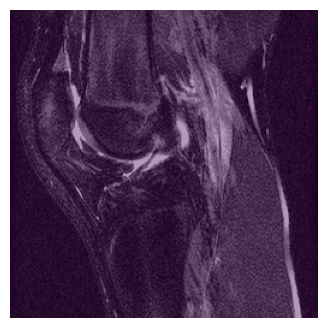

In [23]:
mid = v_uint8.shape[0] // 2
visualize_cam_on_slice(v_uint8, slice_idx=mid, model=model)


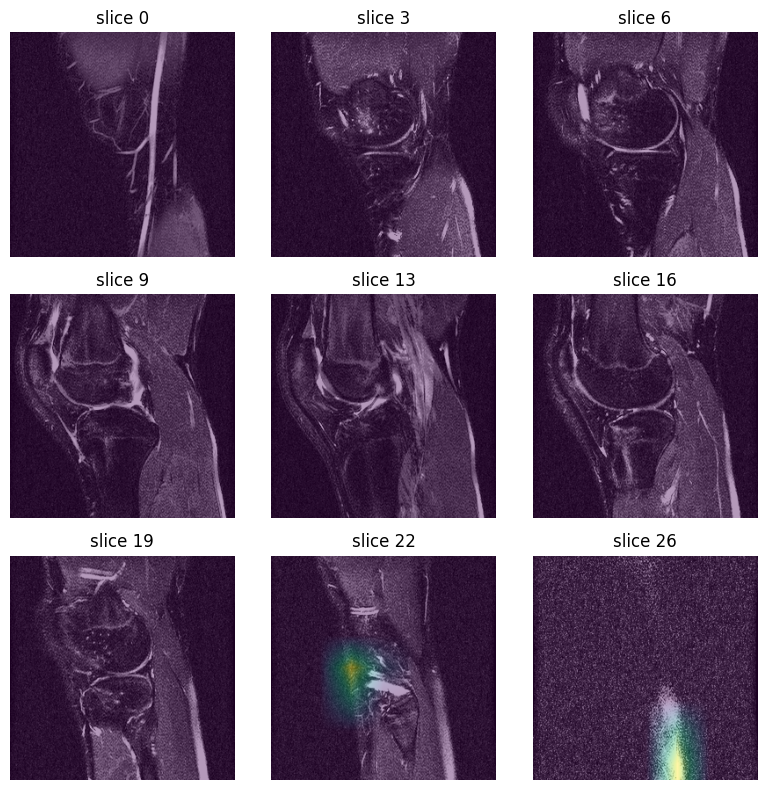

In [24]:
import matplotlib.pyplot as plt

num_to_show = 9
indices = np.linspace(0, v_uint8.shape[0]-1, num_to_show, dtype=int)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.ravel()

for ax, idx in zip(axes, indices):
    img = v_uint8[idx].astype(np.float32)/255.0
    tensor = torch.from_numpy(img).unsqueeze(0)  # [1,3,256,256]
    heat = generate_cam(model, tensor)
    base = np.transpose(v_uint8[idx], (1,2,0))
    ax.imshow(base)
    ax.imshow(heat, alpha=0.4)
    ax.set_title(f"slice {idx}")
    ax.axis("off")

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


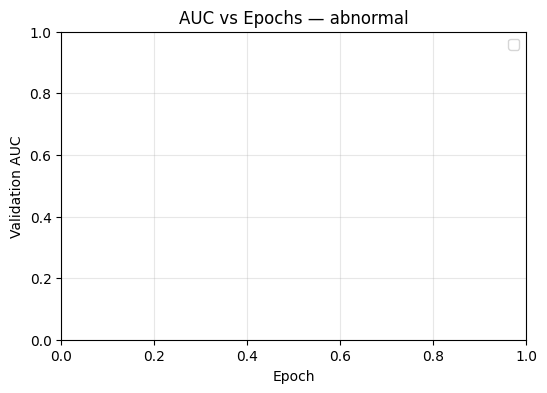

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


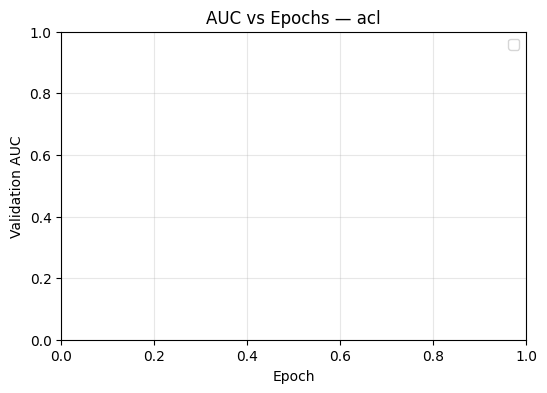

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


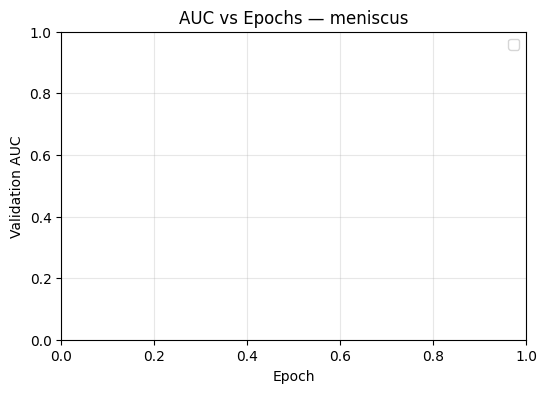

In [30]:
# === Plot AUC vs Epochs (NEW) ===
import matplotlib.pyplot as plt
try:
    AUC_REPORT
except NameError:
    AUC_REPORT = {}
if not AUC_REPORT:
    print('AUC_REPORT not found — run training to populate.')
else:
    for task in TASKS:
        plt.figure(figsize=(6,4))
        for plane in PLANES.keys():
            aucs = AUC_REPORT.get(plane, {}).get(task, [])
            if len(aucs) == 0:
                continue
            plt.plot(range(1, len(aucs)+1), aucs, label=plane)
        plt.xlabel('Epoch')
        plt.ylabel('Validation AUC')
        plt.title(f'AUC vs Epochs — {task}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
